In [82]:
import dlib
import numpy as np
import pandas as pd
import cv2
import colorsys
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pickle
from sklearn.externals import joblib

%matplotlib inline

        
def face_detection(file):
    
    ## face detector와 landmark predictor 정의
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # 파일에서 이미지 불러오기
    file_name=file
    
    # 파일 이름과 확장자 분리
    name=file_name.split(".")[0]
    ext=file_name.split(".")[1]

    img=dlib.load_rgb_image(file_name)

    cvImg=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    #이미지를 두배로 키움
    cvImg = cv2.resize(cvImg, None, fx=2, fy=2, interpolation=cv2.INTER_AREA)

    # 얼굴 인식 두번째 변수 1은 업샘플링을 한번 하겠다는 얘기
    # 업샘플링을하면 더 많이 인식할 수 있음
    # 값이 커질수록 느리고 메모리도 많이 잡아먹음
    dets = detector(img, 1)
    
    # 입술 좌표를 담는 리스트
    lip_x=[]
    lip_y=[]

    # 인식된 얼굴 개수 출력 
    print("Number of faces detected: {}".format(len(dets)))

    # 인식된 얼굴 개수만큼 반복하여 얼굴 윤곽 표시
    for k, d in enumerate(dets):
        # k 얼굴 인덱스
        # d 얼굴 좌표
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

        # 인식된 좌표에서 랜드마크 추출 
        shape = predictor(img, d)
        print(shape.num_parts)
        
        # num_parts(랜드마크 구조체)를 하나씩 접근
        for i in range(0, shape.num_parts):
            
            # 해당 x,y 좌표를 두배로 키워 좌표를 얻음
            x = shape.part(i).x*2
            y = shape.part(i).y*2
            
            # 입술 랜드마크범위에 해당하는 좌표 
            if(48<=i & i<=60):
                lip_x.append(x)
                lip_y.append(y)

            # 이미지 랜드마크 좌표 지점에 인덱스(랜드마크번호, 여기선 i)를 putText로 표시
            # cv2.putText(cvImg, str(i), (x, y), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.3, (0, 255, 0))                    

    # 입술 crop
    src=cvImg
    dst=src.copy()
    dst=src[min(lip_y):max(lip_y),min(lip_x):max(lip_x)]
    
    # 입술 저장
    lip_file=name+"_lip."+ext
    cv2.imwrite(name+"_lip."+ext, dst)
    
    # 입술 저장된 파일 이름 return
    return lip_file

def tracking(img_name): # img_name = 추출할 이미지 경로 혹은 이름
    
    img = cv2.imread(img_name) 
    
    # 입술색 추출 범위
    lower_red = np.array([100, 0, 0]) 
    upper_red = np.array([255, 120, 200])

    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    red_range = cv2.inRange(hsv,lower_red,upper_red)

    red_result = cv2.bitwise_and(img,img,mask = red_range)
    red_result = cv2.resize(red_result,(300,300))

    img = cv2.resize(img,(300,300))


    #추출한 이미지 저장
    cv2.imwrite('result1.PNG', red_result)
    
    return

def centroid_histogram(clt):
    
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

# 색분율 시각화
def plot_colors(hist, centroids):
    
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

def image_color_cluster():
    image = cv2.imread("result1.PNG")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3)) # height, width 통합
    
    # K-Means Clustering
    k = 5 
    clt = KMeans(n_clusters = k,random_state=5) 
    clt.fit(image)
    
    # 색 분율
    hist = centroid_histogram(clt)
    
    print("=====분율====")
    print(hist)
    print("=====rgb=====")
    for center in clt.cluster_centers_:
        print(center)
    print("=====max red=====")
    max_val = 0 
    max_red = []
    
    # 검은색을 제외한 색 분율이 가장 높은 색의 r,g,b 값을 가져옴
    i = 0
    for center in clt.cluster_centers_ :
        if center[0]>1 and center[1]>1 and center[2]>1 and max_val < hist[i] :
            max_val = hist[i]
            max_red=center.copy()
        i=i+1
        
    print(max_red)

    bar = plot_colors(hist, clt.cluster_centers_)

    # show our color bart
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()

    return max_red

# 최종 테스트
def result(max_red):
    
    # 모델 불러오기
    rf_clf = joblib.load('RF_model.pkl') 
    
    bg_clf = joblib.load('BG_model.pkl') 

    # input 이미지의 r,g,b 추출값
    r,g,b=max_red
    h,s,v=colorsys.rgb_to_hsv(r,g,b)
    inputs=[[r,g,b,h,s]]
    inputlist=np.array(inputs)
    inputlist.reshape(-1,1)

    # 예측
    rf_pred=rf_clf.predict(inputlist)
    bg_pred=bg_clf.predict(inputlist)

    # 예측한 립스틱 name 찾기
    test=pd.read_csv("data_with_mode_s.csv")
    
    mode_list=test.drop_duplicates(['name'],keep='first')
    
    rf=mode_list[mode_list["mode"]==rf_pred[0]]
    bg=mode_list[mode_list["mode"]==bg_pred[0]]
    
    print("Random Forest Model이 예측한 립스틱: ", list(rf["name"]))
    print("Bagging Model이 예측한 립스틱: ", list(bg["name"]))
    
    return

Number of faces detected: 1
Detection 0: Left: 167 Top: 133 Right: 322 Bottom: 288
68
=====분율====
[0.58034444 0.09196667 0.0701     0.15744444 0.10014444]
=====rgb=====
[1.48632248 0.65420471 0.70418653]
[217.98972934  37.62916868  59.2257129 ]
[115.98685877  47.83438885  51.73084231]
[200.22336745   6.98623367  10.56837275]
[223.69757885  83.70068858 108.83296313]
=====max red=====
[200.22336745   6.98623367  10.56837275]


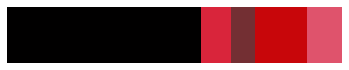

Random Forest Model이 예측한 립스틱:  ['GorgioArmani_lipmagnet400', 'CHANEL_TRUERED', 'YSL_ROUGE', 'est_imotal']
Bagging Model이 예측한 립스틱:  ['GorgioArmani_lipmagnet400', 'CHANEL_TRUERED', 'YSL_ROUGE', 'est_imotal']


In [87]:
# 이미지 경로
file_name="수지.jpg"
# 추출한 입술 이미지 경로
lip_file=face_detection(file_name)
# 색 범위 masking
tracking(lip_file)
# 색 추출
max_red=image_color_cluster()
# 최종 예측
result(max_red)